In [36]:
# Insert the plots into the notebook
%matplotlib inline

In [37]:
from __future__ import division
import datetime
import zipfile
import cPickle as pickle
import itertools
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import multiprocessing
import seaborn  # Makes the default style of the plots nicer

print("Working right now....")

Working right now....


In [38]:
import warnings
warnings.simplefilter('ignore')

In [39]:
from fatiando.vis import mpl
from fatiando.gravmag import tesseroid
from fatiando import gridder, utils
from fatiando.inversion import Smoothness2D
import fatiando

In [40]:
print("Version of Fatiando a Terra used: {}".format(fatiando.__version__))

Version of Fatiando a Terra used: 0.5


In [41]:
from datasets import fetch_assumpcao_moho_points
from mohoinv import (MohoGravityInvSpherical, TesseroidRelief, make_mesh,
                     split_data, score_test_set, score_seismic_constraints, 
                     score_all, fit_all, predict_seismic)

In [42]:
ncpu = multiprocessing.cpu_count()
print("Number of cores: {}".format(ncpu))

Number of cores: 8


In [43]:
with open('../data/processed-data-malawi.txt') as f:
    for i in range(3):  # Skip the first 2 header lines
        line = f.readline()
    full_shape = [int(x) for x in line.split()[1:]]
    full_lat, full_lon, full_height, full_grav = np.loadtxt(f, usecols=[0, 1, 2, -1], 
                                                            unpack=True)
    full_data = [full_lat, full_lon, full_height, full_grav]
print('Number of data points in lat and lon: {}'.format(full_shape))

Number of data points in lat and lon: [44, 19]


In [44]:
full_area = (full_lat.min(), full_lat.max(), full_lon.min(), full_lon.max())
bm = Basemap(projection='cyl', 
             llcrnrlon=full_area[2], urcrnrlon=full_area[3], 
             llcrnrlat=full_area[0], urcrnrlat=full_area[1],
             resolution='l')

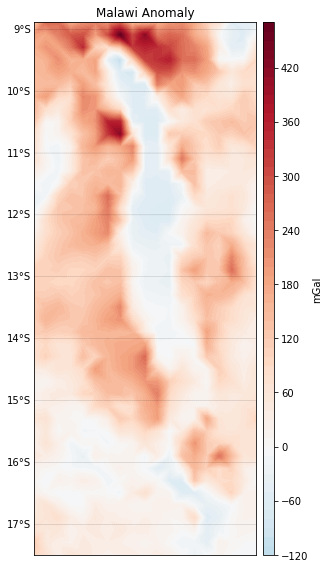

In [45]:
x, y = bm(full_lon, full_lat)
ranges = np.abs([full_grav.min(), full_grav.max()]).max()

plt.figure(figsize=(10, 8))
plt.title('Malawi Anomaly')
plt.grid(True)
plt.rc('grid', linestyle="-", color='black')
bm.contourf(x, y, full_grav, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 1), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 1), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

In [49]:
###CROSS-VALIDATION

inversion_set, test_set, shape = split_data(full_data, full_shape, every_other=2)

print("Number of inversion grid points: {} x {} = {}".format(shape[0], shape[1], 
                                                             shape[0]*shape[1]))
print("Number of test set points: {}".format(test_set[0].size))

Number of inversion grid points: 22 x 10 = 220
Number of test set points: 616


In [50]:
lat, lon, height, data = inversion_set

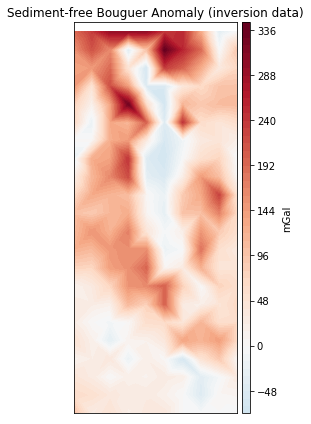

In [51]:
x, y = bm(lon, lat)
ranges = np.abs([data.min(), data.max()]).max()

plt.figure(figsize=(7, 6))
plt.title('Sediment-free Bouguer Anomaly (inversion data)')
bm.contourf(x, y, data, 60, tri=True, cmap='RdBu_r', vmin=-ranges, vmax=ranges)
plt.colorbar(pad=0.01, aspect=50).set_label('mGal')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
plt.tight_layout()

In [52]:
test_points = fetch_assumpcao_moho_points('../data/Moho_Map_SAm2013_data.tar.gz', 
                                          todepth=True, return_height=False)[:-1]

In [53]:
test_points[1] += 360

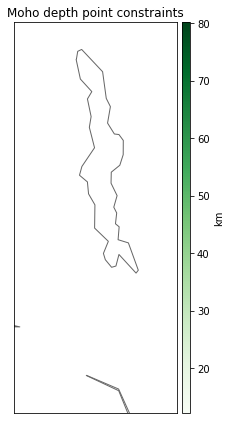

In [54]:
x, y = bm(test_points[1], test_points[0])

plt.figure(figsize=(7, 6))
plt.title('Moho depth point constraints')
bm.scatter(x, y, c=-0.001*test_points[-1], s=20, cmap='Greens')
plt.colorbar(pad=0.01, aspect=50).set_label('km')
bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
bm.drawcoastlines(color="#666666")
plt.tight_layout()

In [55]:
area = (lat.min(), lat.max(), lon.min(), lon.max())
mesh = make_mesh(area, shape)

In [56]:
misfit = MohoGravityInvSpherical(lat, lon, height, data, mesh)
regul = Smoothness2D(mesh.shape)
initial = -60e3*np.ones(mesh.size)  
# The initial estimate doesn't really matter too much

In [57]:
def plot_fit(lat, lon, data, solution, bm):    
    ranges = np.abs([data.max(), data.min()]).max()
    
    plt.figure(figsize=(7, 6))
    plt.title('Observed (color) and predicted (contour) data')    
    levels = mpl.contourf(lon, lat, data, shape, 40, cmap='RdBu_r', basemap=bm, 
                          vmin=-ranges, vmax=ranges)
    plt.colorbar(pad=0.01).set_label('mGal')
    mpl.contour(lon, lat, solution[0].predicted(), shape, levels, 
                basemap=bm, color='#333333')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_residuals(solution):
    residuals = solution[0].residuals()
    
    plt.figure(figsize=(3, 2.5))
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(residuals.mean(), residuals.std()), 
             transform=plt.gca().transAxes)
    plt.hist(residuals, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Residuals (mGal)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_estimate(solution, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    
    plt.figure(figsize=(7, 6))
    plt.title("Estimated Moho depth")
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01).set_label('km')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 0, 1], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic(solution, test_points, bm):
    moho = solution.estimate_
    x, y = bm(moho.lons, moho.lats)
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))
    ranges = np.abs([diff.max(), diff.min()]).max()
    lat, lon, depth = test_points
    xp, yp = bm(lon, lat)
   
    fig = plt.figure(figsize=(7, 6))
    bm.pcolormesh(x, y, -0.001*moho.relief.reshape(moho.shape), cmap='Greens')
    plt.colorbar(pad=0.01, aspect=50).set_label('Estimated Moho depth (km)')
    bm.scatter(xp, yp, c=diff, s=40, cmap='PuOr_r', 
                     vmin=-ranges, vmax=ranges, linewidths=0.1)
    cb = plt.colorbar(pad=0.01, aspect=50)
    cb.set_label('Difference between seismic and estimated (km)')
    bm.drawmeridians(np.arange(-80, -30, 10), labels=[0, 0, 1, 0], linewidth=0.2)
    bm.drawparallels(np.arange(-50, 30, 15), labels=[1, 0, 0, 0], linewidth=0.2)
    plt.tight_layout(pad=0)
    
def plot_diff_seismic_hist(solution, test_points):
    moho = solution.estimate_
    diff = -0.001*(test_points[-1] - predict_seismic(moho, *test_points[:2]))

    plt.figure(figsize=(3, 2.5))
    plt.title('Difference (seismic points)')
    plt.text(0.65, 0.8, 
             "mean = {:.2f}\nstd = {:.2f}".format(diff.mean(), diff.std()), 
             transform=plt.gca().transAxes)
    # Use the line above so the text coordinates are in axes coordinates (0 to 1)
    # instead of data coordinates, which may vary between runs.
    plt.hist(diff, bins=20, normed=True, histtype='stepfilled')
    plt.xlabel('Differences (km)')
    plt.ylabel('Normalized frequency')
    plt.tight_layout(pad=0)
    
def plot_cv_regul(regul_params, scores, best, log=True): 
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (regularization parameter)')
    plt.plot(regul_params, scores, marker='o')
    plt.plot(regul_params[best], scores[best], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    plt.legend(loc='upper left')
    plt.xscale('log')
    if log:
        plt.yscale('log')
    plt.xlabel('Regularization parameter')
    plt.ylabel(u'Mean Square Error')
    plt.tight_layout(pad=0)
    
def plot_cv_ref_dens(densities, reference_levels, scores, best_dens, best_ref):
    plt.figure(figsize=(5, 3))
    plt.title('Cross-validation (reference level and density)')
    plt.contourf(-0.001*reference_levels, densities, scores, 30, cmap='BuPu_r')
    plt.colorbar(pad=0.01).set_label('Mean Square Error')
    plt.plot(-0.001*reference_levels[best_ref], densities[best_dens], 's', markersize=10, 
             color=seaborn.color_palette()[2], label='Minimum')
    l = plt.legend(loc='upper left')
    for txt in l.get_texts():
        txt.set_color('#ffffff')
    plt.xlabel('Reference level (km)')
    plt.ylabel(u'Density contrast (kg/m³)')
    plt.tight_layout(pad=0)
    
def plot_convergence(solution, log=True):
    plt.figure(figsize=(5, 3))
    plt.title('Convergence')
    plt.plot(range(solution.stats_['iterations'] + 1), solution.stats_['objective'])
    plt.xlabel('Iteration')
    plt.ylabel('Goal function')
    if log:
        plt.yscale('log')
    plt.tight_layout(pad=0)

In [58]:
results = dict()

In [59]:
results['config'] = dict(method='newton', initial=initial, tol=0.2, maxit=6)

In [60]:
results['regul_params'] = np.logspace(-10, -2, 16)
results['regul_params']

array([  1.00000000e-10,   3.41454887e-10,   1.16591440e-09,
         3.98107171e-09,   1.35935639e-08,   4.64158883e-08,
         1.58489319e-07,   5.41169527e-07,   1.84784980e-06,
         6.30957344e-06,   2.15443469e-05,   7.35642254e-05,
         2.51188643e-04,   8.57695899e-04,   2.92864456e-03,
         1.00000000e-02])

In [61]:
results['reference_levels'] = np.arange(-40e3, -20e3 + 1, 2500)
results['reference_levels']

array([-40000., -37500., -35000., -32500., -30000., -27500., -25000.,
       -22500., -20000.])

In [62]:
results['densities'] = np.arange(200, 500 + 1, 50)
results['densities']

array([200, 250, 300, 350, 400, 450, 500])

In [63]:
misfit.set_density(results['densities'][-1]).set_reference(results['reference_levels'][-1])

In [64]:
solvers = [(misfit + mu*regul).config(**results['config']) 
           for mu in results['regul_params']]

%time solutions = fit_all(solvers, njobs=ncpu)

Wall time: 20.2 s


In [65]:
results['models_regul'] = [s.estimate_ for s in solutions]

In [66]:
def pickle_results(results, intermediate=False):
    now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
    results['metadata'] = "Generated by south-america-moho.ipynb on {date}".format(
        date=now)
    if intermediate:
        fname = 'results/south-america-moho.intermediate.pickle'
    else:
        fname = 'results/south-america-moho.pickle'
    with open(fname, 'w') as f:
        pickle.dump(results, f)

In [67]:
pickle_results(results, intermediate=True)

In [68]:
%%time 
results['scores_regul'] = score_all(results['models_regul'], test_set, points=False, 
                                    njobs=ncpu)

Wall time: 19.3 s


In [69]:
best_regul = np.argmin(results['scores_regul'])
results['best_regul'] = best_regul

In [70]:
results['solution_regul'] = solutions[best_regul]

In [71]:
pickle_results(results, intermediate=True)

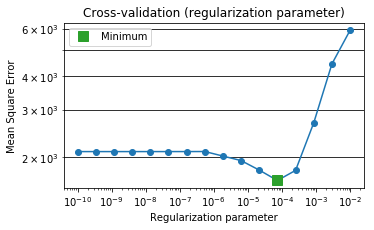

In [72]:
plot_cv_regul(results['regul_params'], results['scores_regul'], 
              best_regul, log=True)
plt.grid(True, which='both', axis='y')

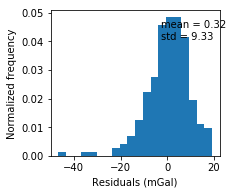

In [73]:
plot_residuals(results['solution_regul'])

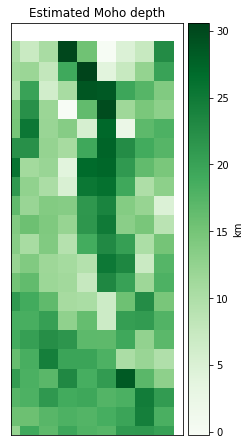

In [74]:
plot_estimate(results['solution_regul'], bm)

In [75]:
def set_ref_dens(solver, ref, dens):
    """
    Configure the solver to use this reference level and density.
    """
    res = solver.copy(deep=True)
    # res is a multi-objective with the misfit function + regularization
    # res[0] is the misfit (our inversion class)
    # res[1] is the Smoothness2D instance
    res[0].set_density(dens).set_reference(ref)
    return res

In [76]:
solvers = [set_ref_dens(results['solution_regul'], ref, dens) 
           for dens in results['densities'] 
           for ref in results['reference_levels']]

%time solutions = fit_all(solvers, njobs=ncpu)

Wall time: 21 s


In [81]:
results['models_refdens'] = [s.estimate_ for s in solutions]

In [86]:
# Reshape the scores array because it should be a matrix 
# with density as the rows and reference level as the columns.
# This will make it easier for us to find the best density and reference level below.
cv_shape = (len(results['densities']), len(results['reference_levels']))
results['scores_refdens'] = score_all(results['models_refdens'], 
                                      test_points, points=True).reshape(cv_shape)

In [91]:
best = np.nanargmin(results['scores_refdens'])
# Find the index in reference_levels and densities corresponding to best
results['best_dens'], results['best_ref'] = np.unravel_index(best, cv_shape)
results['solution'] = solutions[best]

ValueError: All-NaN slice encountered

In [92]:
estimated_ref = results['reference_levels'][results['best_ref']]
estimated_dens = results['densities'][results['best_dens']]
estimated_regul = results['regul_params'][results['best_regul']]
print('Cross-validation results:')
print(u'  reference level: {} km'.format(-0.001*estimated_ref))
print(u'  density contrast: {} kg/m³'.format(estimated_dens))
print(u'  regularization parameter: {}'.format(estimated_regul))

KeyError: 'best_ref'

# SAVING THE MALAWIAN DATA

In [126]:
pickle_results(results, intermediate=False)

In [127]:
fname = 'south-america-moho'
pickle_file = '{}.pickle'.format(fname)
# Zip the pickle file
zipargs = dict(mode='w', compression=zipfile.ZIP_DEFLATED)
with zipfile.ZipFile('results/{}.zip'.format(fname), **zipargs) as f:
    f.write('results/{}'.format(pickle_file), arcname=pickle_file)

In [128]:
%%bash
cd results/
split -b 30M --numeric-suffixes=1 south-america-moho.zip south-america-moho.zip.part
cd ..

In [129]:
now = datetime.datetime.utcnow().strftime('%d %B %Y %H:%M:%S UTC')
moho = results['solution'].estimate_
header = """# Moho of Malawi estimated by gravity data inversion
# See the source code for the inversion at:
#   https://github.com/pinga-lab/paper-moho-inversion-tesseroids
# Generated by south-america-moho.ipynb on {date}
# Model grid shape (nlat, nlon):
#   {nlat} {nlon}
# Latitude and longitude values correspond to the center of each
# model cell.
# Moho depth is provided in meters.
# Columns:
# lat lon Moho_depth
""".format(date=now, nlat=moho.shape[0], nlon=moho.shape[1])
with open('../model/south-america-moho.txt', 'w') as f:
    f.write(header)
    np.savetxt(f, np.c_[moho.clat.ravel(), moho.clon.ravel(), -moho.relief],
               fmt='%.5f')

KeyError: 'solution'